In [1]:
#pip install    --no-index --find-links ../input/sourcelib segmentation_models_pytorch

In [2]:
#! ls -la ../input/source

In [3]:
#!pip wheel mypackage -w ../input/source --no-deps

In [4]:
#!pip install --no-index --find-links="../input/source" segmentation_models_pytorch

In [5]:
import os
import random
import math

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import zoom
from torchvision import transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import tifffile as tiff
import torch.nn as nn
from scipy import ndimage
from PIL import Image
from skimage import transform
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import StepLR
import lovasz_losses as L
from torch.nn.functional import interpolate
import cv2

In [6]:
class config:
    seed = 1717
    #base_path = "../input/hubmap-organ-segmentation" #UNCOMMIT FOR KAGGLE
    base_path = "./hubmap-organ-segmentation"
    batch_size = 16
    
    val_size = 0.25
    
    epoch = 5
    lr = 3e-3
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    rescaling_factor = 3
    
    crop_size = 256
    crop_amount = 8
    base_size = 512
    
    
    train_metadata = os.path.join(base_path, "train.csv")
    test_metadata = os.path.join(base_path, "test.csv")
    train_images = os.path.join(base_path, "train_images")
    test_images = os.path.join(base_path, "test_images")
    
    model_path = "model4"
    
    random.seed(seed)
    torch.manual_seed(seed)
    

In [7]:
# https://www.kaggle.com/paulorzp/rle-functions-run-length-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [8]:
class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, data):
        image, mask = data["image"], data["mask"]
        
        h, w = image.shape[1:]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[:, top: top + new_h,
                      left: left + new_w]
        mask = mask[:, top: top + new_h,
                      left: left + new_w]

        return {"image": image, "mask": mask}

In [9]:
class BaselineDataset(Dataset):
    def __init__(
        self, root_dir, metadata,
        image_transforms=None, mask_transforms=None,
        rescaling_factor = config.rescaling_factor,
        crop_size = 1, crop_amount = 1, val = False,
        base_zie = config.base_size
    ):
        self.root_dir = root_dir
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        self.crop = RandomCrop(crop_size)
        self.crop_amount = crop_amount
        self.val = val
        self.base_zie = base_zie
        self.new_voxel_spacing = np.array(
            [
                3,
                0.171 * rescaling_factor,
                0.171 * rescaling_factor
            ]
        )
        cur_ids = set(metadata["id"])
        files = [
            x for x in os.listdir(self.root_dir) if int(
                x.split(".")[0]
            ) in cur_ids
        ]
        self.idx2name = {
            x: os.path.join(self.root_dir, y)
            for x, y in enumerate(files)
        }

        self.name2idx = {
            int(y.split(".")[-2].split("/")[-1]): x
            for x, y in self.idx2name.items()
        }
        
        self.idx2meta = {
            self.name2idx[x[1]["id"]]: {
                "mask": None,
                "pixel_size": x[1]["pixel_size"],
                "tissue_thickness": x[1]["tissue_thickness"],
                "id": x[1]["id"],
                "img_width": x[1]["img_width"],
                "img_height": x[1]["img_height"],
            }
            for x in metadata.iterrows()
        }
        for x in metadata.iterrows():
            if x[1].get("rle") is not None:
                self.idx2meta[self.name2idx[x[1]["id"]]]["mask"] = rle2mask(
                    x[1]["rle"],
                    (x[1]["img_width"], x[1]["img_height"])
                )
    
    def get_voxel_size(self, idx):
        image = load(self.idx2name[idx])
        return np.array(image[1].get_voxel_spacing())
    
    def zoom(self, data, zoom_scale):
        image, mask = data['image'], data['mask']

        h, w = image.shape[:2]
        h *= zoom_scale
        w *= zoom_scale
        h = int(h)
        w = int(w)
        h = int(2 ** round(math.log(h, 2) - 2))
        w = int(2 ** round(math.log(w, 2) - 2))
        h = self.base_zie
        w = self.base_zie
        img = transform.resize(image, (h, w))
        if mask is not None:
            mask = transform.resize(mask, (h, w))
        mask[mask != 0] = 1
        #a = plt.imshow(img)
        #plt.show()
        #b = plt.imshow(mask)
        #plt.show()
        return {'image': img, 'mask': mask}
    
    def to_image(self, data):
        ans =  {
            'image': Image.fromarray((data['image'] * 255).astype(np.uint8)),
            'mask': None
        }
        if data["mask"] is not None:
            ans["mask"] = Image.fromarray((data['mask'] * 255).astype(np.uint8))
        return ans
    
    def __len__(self):
        return len(self.idx2name)
        #return len(self.idx2name) * self.crop_amount if not self.val else len(self.idx2name)
    
    def __getitem__(self, idx_):
        idx = idx_ // self.crop_amount
        image = tiff.imread(self.idx2name[idx])
        mask = self.idx2meta[idx]["mask"]

        #TODO Use pixel_size and tissue_thickness here
        ans = {"image": image, "mask": mask}
        ans = self.zoom(ans, self.idx2meta[idx]["pixel_size"])
        ans = self.to_image(ans)
   
        if self.image_transforms:
            ans["image"] = self.image_transforms(ans["image"])
        if self.mask_transforms and ans["mask"] is not None:
            ans["mask"] = self.mask_transforms(ans["mask"])
        else:
            ans["mask"] = 0
        ##aa = torch.permute(ans["image"] , (1, 2, 0))
        #aa = ans["image"]
        #bb = ans["mask"]
        #aa = torch.permute(aa, (1, 2, 0))
        #bb = torch.permute(bb, (1, 2, 0))
        
        #cc = transform.resize(bb , (256, 256))
        #cc[cc != 0] = 1
        #a = plt.imshow(aa)
        #plt.show()
        #b = plt.imshow(bb)
        #plt.show()
        #b = plt.imshow(cc)
        #plt.show()
        ans["id"] = self.idx2meta[idx]["id"]
        ans["img_width"] = self.idx2meta[idx]["img_width"]
        ans["img_height"] = self.idx2meta[idx]["img_height"]
        return ans

In [10]:
a = np.array([1,2,3])
print(a[a > 0])

[1 2 3]


In [11]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = smp.UnetPlusPlus("efficientnet-b4", classes=1, in_channels=3)
    
    def forward(self, x):
        ans = self.backbone(x)
        return torch.sigmoid(ans)

In [12]:
def dice_loss(logit, target):
    #pred = torch.sigmoid(logit)
    pred = logit
    
    sum_dims = list(range(1, target.dim()))
    dice = 2 * torch.sum(pred * target, dim = sum_dims) / torch.sum(pred ** 2 + target ** 2, dim = sum_dims)
    loss = 1 - dice
    return loss.mean()

In [13]:
def symmetric_lovasz(outputs, targets):
    return 0.5*(L.lovasz_hinge(outputs, targets) + L.lovasz_hinge(-outputs, 1.0 - targets))

In [14]:
def final_loss(outputs, targets):
    return dice_loss(outputs, targets) + symmetric_lovasz(outputs, targets)

In [15]:
df_train_source = pd.read_csv(config.train_metadata)
df_train = df_train_source.sample(frac=1, random_state=config.seed).reset_index(drop=True)[:300]
df_val = df_train_source.sample(frac=1, random_state=config.seed).reset_index(drop=True)[300:]

df_test = pd.read_csv(config.test_metadata)
df_train.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,32231,spleen,HPA,3000,3000,0.4,4,1399958 26 1402957 29 1405956 32 1408947 48 14...,72.0,Male
1,27471,prostate,HPA,3000,3000,0.4,4,1105636 28 1105755 13 1108635 30 1108754 16 11...,76.0,Male
2,5086,lung,HPA,3000,3000,0.4,4,1510934 32 1513930 36 1516928 38 1519926 40 15...,65.0,Male
3,8343,lung,HPA,3000,3000,0.4,4,2170394 3 2173394 6 2176394 7 2179395 7 218239...,49.0,Female
4,25620,kidney,HPA,3000,3000,0.4,4,2062029 24 2065028 27 2068024 36 2071022 41 20...,28.0,Male


In [16]:
df_train_source

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male


In [17]:
general_transforms = [
    transforms.ToTensor(),
]
image_transforms = transforms.Compose(
    general_transforms + [
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)
mask_transforms = transforms.Compose(general_transforms)

In [18]:
train_dataset = BaselineDataset(
    config.train_images, df_train,
    image_transforms = image_transforms,
    mask_transforms = mask_transforms,
    crop_size = config.crop_size,
    crop_amount = config.crop_amount,
    val = False
)
val_dataset = BaselineDataset(
    config.train_images, df_val,
    image_transforms = image_transforms,
    mask_transforms = mask_transforms,
    val = True
)
test_dataset = BaselineDataset(
    config.test_images, df_test,
    image_transforms = image_transforms,
    mask_transforms = mask_transforms,
    val = True
)

In [19]:
train_dataloader = DataLoader(
    train_dataset, batch_size=config.batch_size,
    shuffle=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=1,
    shuffle=True
)
test_dataloader = DataLoader(
    test_dataset, batch_size=1,
    shuffle=False
)

In [20]:
model = BaselineModel()
model = model.to(config.device)

optimizer = torch.optim.Adam(
    model.parameters(),
    config.lr
)
scheduler = StepLR(optimizer, step_size=2, gamma=0.95)

In [21]:
import copy
to_tensor = transforms.ToTensor()
to_image = transforms.ToPILImage()
def val(model, loss_fn, val_dataloader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for x in val_dataloader:
            mask_pred = model(x["image"].to(device))
            loss = loss_fn(
                mask_pred, 
                x["mask"].to(device)
            )
            val_loss.append(loss.item())
            
    return sum(val_loss) / len(val_loss)

In [22]:
def train(model, optimizer, scheduler, loss_fn, train_dataloader, val_dataloader, epochs, device):
    for epoch in range(epochs):
        train_loss = []
        model.train()
        for step, x in enumerate(train_dataloader):
            model.zero_grad()
            mask_pred = model(x["image"].to(device))

            loss = loss_fn(
                mask_pred,
                x["mask"].to(device)
            )

            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            if (step + 1) % 50 == 0:
                print(f"Step {step} Train loss: {sum(train_loss) / len(train_loss)}")

        val_loss = val(model, loss_fn, val_dataloader, device)

        print(f"Train loss: {sum(train_loss) / len(train_loss)}")
        print(f"Val loss: {val_loss}")
        torch.save(model, os.path.join(config.model_path, f"model_{epoch}"))
        scheduler.step()

In [23]:
train(model, optimizer, scheduler, final_loss, train_dataloader, val_dataloader, config.epoch, config.device)

Train loss: 1.526438179769014
Val loss: 2.2504742402656404
Train loss: 1.1740183704777767
Val loss: 1.6790410841212553
Train loss: 1.0977361829657304
Val loss: 1.7809732427784042
Train loss: 1.067192083910892
Val loss: 1.7888914720684874
Train loss: 1.0449805887121904
Val loss: 1.6726453538034476


In [25]:
#model_inference = BaselineModel()
#model_inference = model_inference.to(config.device)

model = torch.load(
    os.path.join(config.model_path, f"model_{4}")
)
model = model.to(config.device)

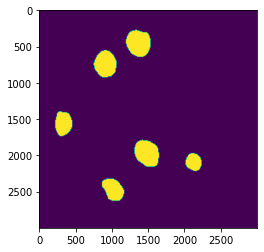

In [103]:
model.eval()
ids = []
masks = []
to_img = transforms.ToPILImage()
to_tns = transforms.ToTensor()

with torch.no_grad():
    for x in val_dataloader:
        image = x["image"]
        mask_pred = model(image.to(config.device)).to("cpu")
        mask_pred = mask_pred.view(mask_pred.shape[1:])
        mask_pred = torch.permute(mask_pred, (1, 2, 0))
        mask_pred = cv2.resize(mask_pred.numpy(), (int(x["img_height"]), int(x["img_width"])), interpolation = cv2.INTER_AREA)
        mask_pred = to_tensor(mask_pred)
        
        mask_pred = (mask_pred >= 0.5).int()
        #b = mask_pred
        #b = torch.permute(b, (1, 2, 0))
        #bb = plt.imshow(b)
        #plt.show()

        
        ids.append(int(x["id"]))
        masks.append(mask2rle(mask_pred.view(mask_pred.shape[1:])))


In [ ]:
ids, masks

In [ ]:
df = pd.DataFrame({'id':ids,'rle':masks})
df.to_csv('submission.csv',index=False)

In [ ]:
! head submission.csv